In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

class StrategyYFinance:
    def __init__(self, benchmark_symbol, symbol,start, end, interval, risk_free_rate = 0):
        self.params = {
            "benchmark_symbol": benchmark_symbol,
            "symbol": symbol,
            "start": start,
            "end": end,
            "interval": interval,
            "risk_free_rate": risk_free_rate
        }
        self.data = self.prepare_data(symbol=symbol, start=start, end=end, interval=interval)
        self.benchmark = self.prepare_data(symbol=benchmark_symbol, start=start, end=end, interval=interval)
        self.trades = None
        self.performance = {}

    def prepare_data(self, symbol, start, end, interval):
        data = yf.Ticker(symbol)
        df = data.history(start=start, end=end, interval=interval).reset_index()
        df['timestamp_utc'] = (pd.to_datetime(df['Date'])
                                    .dt.tz_convert('UTC')
                                    .astype(int) // 10**6)
        df['returns_close'] = (df['Close'] / df['Close'].shift(1)) - 1
        df['logreturns_close'] = np.log(df['Close'] / df['Close'].shift(1))
        return df.sort_values(by = 'timestamp_utc').reset_index(drop=True)
    def strategy(self):
        """
        Generate a signal column, 1 for Long, 0 for Short.
        """
        raise NotImplementedError("Subclasses must implement strategy method")
    
    """
    Calculate Trades
    """
    def calculate_trades(self, signal_column='signal', price_column='Close'):
        if self.data is None:
            raise ValueError("No data to calculate trades")
        if self.data[signal_column].mean() == 0:
            print("No trades executed")
            return None, {}
        
        # Identify Trades
        self.data['signal_change'] = self.data[signal_column] != self.data[signal_column].shift(1)
        if self.data['signal_change'].mean() == 0:
            print("No trades executed")
            return None, {}
        trades = []
        open_trade = None

        for idx, row in self.data[self.data['signal_change']].iterrows():
            current_signal = row[signal_column]
            
            if open_trade is None:
                if current_signal != 0:
                    open_trade = {
                        'entry_datetime': datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc),
                        'entry_price': row[price_column],
                        'position': current_signal
                    }
            else:
                exit_datetime = datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc)
                duration = exit_datetime - open_trade['entry_datetime']
                exit_price = row[price_column]
                pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
                pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
                
                trades.append({
                    'entry_datetime': open_trade['entry_datetime'],
                    'exit_datetime': exit_datetime,
                    'duration': duration,
                    'entry_price': open_trade['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'pnl%': pnl_pct,
                    'position': open_trade['position'],
                    'win': 1 if pnl > 0 else 0
                })
                
                if current_signal != 0:
                    # Immediately open a new trade
                    open_trade = {
                        'entry_datetime': exit_datetime,
                        'entry_price': exit_price,
                        'position': current_signal
                    }
                else:
                    open_trade = None
        
        # Close any remaining open trade at the last available price
        if open_trade is not None:
            last_row = self.data.iloc[-1]
            exit_datetime = datetime.fromtimestamp(last_row['timestamp_utc'] / 1000, tz=timezone.utc)
            duration = exit_datetime - open_trade['entry_datetime']
            exit_price = last_row[price_column]
            pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
            pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
            
            trades.append({
                'entry_datetime': open_trade['entry_datetime'],
                'exit_datetime': exit_datetime,
                'duration': duration,
                'entry_price': open_trade['entry_price'],
                'exit_price': exit_price,
                'pnl': pnl,
                'pnl%': pnl_pct,
                'position': open_trade['position'],
                'win': 1 if pnl > 0 else 0
            })
        
        trades_df = pd.DataFrame(trades)
        
        # Calculate performance metrics
        num_trades = len(trades_df)
        win_rate = round(trades_df['win'].mean(), 5)
        avg_win = trades_df[trades_df['win'] == 1]['pnl'].mean()
        avg_loss = abs(trades_df[trades_df['win'] == 0]['pnl'].mean())
        reward_risk_ratio = avg_win / avg_loss if avg_loss != 0 else np.inf
        expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
        avg_duration = trades_df['duration'].mean()
        turnover_rate = len(trades_df) / len(self.data)
        
        performance = {
            'number_of_trades': num_trades,
            'win_rate': win_rate,
            'reward_risk_ratio': reward_risk_ratio,
            'expectancy': expectancy,
            'avg_trade_duration': avg_duration,
            'turnover_rate': turnover_rate
        }
        
        return trades_df, performance
    """
    Evaluate Performance
    """
    def calculate_performance(self):
        """
        Close to Close returns performance analysis of the strategy. 

        Requirements:
        1. Strategy generated : 1 for Long, 0 for Short.

        Data:


        """
        # Previous signal multiplied by Returns
        self.data['returns_strategy'] = self.data['signal'].shift(1) * self.data['returns_close']
        self.data['logreturns_strategy'] = self.data['signal'].shift(1) * self.data['logreturns_close']

        self.performance = {}
        trades, trades_performance = self.calculate_trades()
        self.trades = trades
        self.performance.update(trades_performance)
        # self.performance.update({ 'returns' : self.calculate_returns_metrics()})
        # self.performance.update(self.calculate_risk_metrics())
        self.performance.update(self.calculate_relative_metrics())
        self.performance.update(self.calculate_confidence_metrics())

    """
    Helper Functions
    """
    def calculate_returns_metrics(self):
        """
        Annualized Return: Measures the average yearly return of a strategy.
        Standard Deviation: Indicates the volatility of the return distribution.
        Cumulative Returns: Shows the total return over time.
        Skewness: Measures the asymmetry of the return distribution.
        Kurtosis: Indicates the "tailedness" of the return distribution and potential for extreme outcomes.
        """
        returns_metrics = {}

        def calculate_returns_analysis(dataframe, column_name):
            returns = dataframe[column_name]
            metrics = {}
            metrics['annualized_returns'] = self._calculate_annualized_return(dataframe, column_name)
            metrics['std_returns'] = returns.std()
            metrics['cumulative_returns'] = (1 + returns).prod() - 1
            metrics['skewness'] = returns.skew()
            metrics['kurtosis'] = returns.kurtosis()
            return metrics
        returns_metrics['returns_strategy'] = calculate_returns_analysis(self.data, 'returns_strategy')
        returns_metrics['logreturns_strategy'] = calculate_returns_analysis(self.data, 'logreturns_strategy')
        returns_metrics['returns_benchmark'] = calculate_returns_analysis(self.benchmark, 'returns_close')
        returns_metrics['logreturns_benchmark'] = calculate_returns_analysis(self.benchmark, 'logreturns_close')
        return returns_metrics

    def _calculate_annualized_return(self, dataframe, column_name):
        """
        Calculate the annualized return of the strategy.
        """
        total_return = (1 + dataframe[column_name]).prod() - 1
        n_years = len(dataframe) / 252  # Assuming 252 trading days in a year
        return (1 + total_return) ** (1 / n_years) - 1
    # def calculate_risk_metrics(self):
    #     """
    #     Maximum Drawdown: Indicates the largest percentage drop in a portfolio's value from its peak.
    #     Ulcer Index: Measures the depth and duration of drawdowns in price.
    #     Downside Deviation: Measures the volatility of negative returns, used in calculating the Sortino Ratio.
    #     """

    def _calculate_beta(self, returns_strategy, returns_benchmark):
        """
        Calculate the beta of the strategy relative to the benchmark.
        
        Beta is calculated as the covariance of the strategy returns and the benchmark returns,
        divided by the variance of the benchmark returns.
        
        Formula: β = Cov(r_s, r_b) / Var(r_b)
        where r_s is the strategy returns and r_b is the benchmark returns.
        """
        covariance = np.cov(returns_strategy.dropna(), returns_benchmark.dropna())[0, 1]
        benchmark_variance = np.var(returns_benchmark.dropna())
        if benchmark_variance != 0:
            return covariance / benchmark_variance
        else:
            return np.nan  # Return NaN if benchmark variance is zero to avoid division by zero
    def _calculate_alpha(self, beta, dataframe_strategy, column_strategy, dataframe_benchmark, column_benchmark, risk_free_rate = 0):
        """
        Calculate the alpha of the strategy relative to the benchmark.
        
        Alpha is calculated using the Capital Asset Pricing Model (CAPM):
        α = R_s - [R_f + β(R_b - R_f)]
        
        where:
        R_s = Strategy's return
        R_f = Risk-free rate
        β = Beta of the strategy
        R_b = Benchmark's return
        
        We'll use annualized returns for this calculation.
        """
        # Calculate annualized returns
        annualizedreturns_strategy = self._calculate_annualized_return(dataframe_strategy, column_strategy)
        annualizedreturns_benchmark = self._calculate_annualized_return(dataframe_benchmark, column_benchmark)
        
        # Calculate alpha
        alpha = annualizedreturns_strategy - (risk_free_rate + beta * (annualizedreturns_benchmark - risk_free_rate))
        return alpha 
    def calculate_relative_metrics(self):
        """
        R-Squared: Indicates how closely the portfolio's performance matches the performance of a benchmark.
        Beta: Measures the portfolio's sensitivity to market movements compared to benchmark. If beta is 1, the portfolio moves in line with the benchmark.
        Alpha: Represents the excess return of a strategy after adjusting for market-related risk.
        Sharpe Ratio: Evaluates risk-adjusted performance by relating the excess return of a strategy to its volatility.
        Downside Deviation: Measures the volatility of negative returns, used in calculating the Sortino Ratio.s
        Sortino Ratio: Similar to Sharpe Ratio but considers only downside volatility.
        Maximum Drawdown : The maximum loss from a peak to a trough of a portfolio.
        Calmar Ratio: Compares the annualized return to the maximum drawdown.
        Treynor Ratio: Assesses risk-adjusted returns relative to systematic risk (beta).
        Information Ratio: Evaluates the risk-adjusted return of a portfolio against a benchmark.
        Omega Ratio: Compares the likelihood of achieving returns above a minimum acceptable return to the likelihood of returns below that threshold.
        Profit Factor: The ratio of gross profit to gross loss.
        Recovery Factor: Compares the net profit to the maximum drawdown.
        """

        beta = self._calculate_beta(returns_strategy=self.data['returns_strategy'], returns_benchmark=self.benchmark['returns_close'])
        alpha = self._calculate_alpha(beta=beta, dataframe_strategy=self.data, column_strategy='returns_strategy', dataframe_benchmark=self.benchmark, column_benchmark='returns_close', risk_free_rate=self.params['risk_free_rate'])
        # Sharpe Ratio
        annualized_sharpe = ((self._calculate_annualized_return(self.data, 'returns_strategy') - self.params['risk_free_rate']).mean() / self.data['returns_strategy'].std()) * np.sqrt(252)
        # Sortino Ratio
        downside_returns = self.data['returns_strategy'][self.data['returns_strategy'] < 0]
        downside_std = downside_returns.std()
        annualized_sortino = ((self._calculate_annualized_return(self.data, 'returns_strategy') - self.params['risk_free_rate']).mean() / downside_std) * np.sqrt(252)
        # Calmar Ratio
        cumulative_returns = (1 + self.data['returns_strategy']).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        max_drawdown = drawdown.min()
        annualized_calmar = self._calculate_annualized_return(self.data, 'returns_strategy') / abs(max_drawdown) if max_drawdown != 0 else np.inf
        # Treynor Ratio
        annualized_treynor = (self._calculate_annualized_return(self.data, 'returns_strategy') - self.params['risk_free_rate']) / beta
        # Information Ratio
        annualized_information = (self._calculate_annualized_return(self.data, 'returns_strategy') - self._calculate_annualized_return(self.benchmark, 'returns_close')) / (self.data['returns_strategy'] - self.benchmark['returns_close']).std()
        # Omega Ratio
        """
        Calculate the Omega Ratio of the strategy.

        The Omega Ratio is defined as:
        Omega(threshold) = ∫[threshold to ∞] (1 - F(r)) dr / ∫[-∞ to threshold] F(r) dr

        Where:
        F(r) is the cumulative distribution function of returns
        threshold is the target return (default is 0)

        In practice, we can calculate this using the empirical distribution of returns:
        Omega(threshold) = E[max(r - threshold, 0)] / E[max(threshold - r, 0)]

        Parameters:
        threshold (float): The threshold return (default is 0)

        Returns:
        float: The Omega Ratio
        """
        omega_ratio =  np.mean(np.maximum(self.data['returns_strategy'] - self.params['risk_free_rate'], 0)) / np.mean(np.maximum(self.params['risk_free_rate'] - self.data['returns_strategy'], 0)) if np.mean(np.maximum(self.params['risk_free_rate'] - self.data['returns_strategy'], 0)) != 0 else (np.inf if np.mean(np.maximum(self.data['returns_strategy'] - self.params['risk_free_rate'], 0)) > 0 else 0)
        # Profit Factor
        profit_factor = self.data['returns_strategy'][self.data['returns_strategy'] > 0].sum() / -self.data['returns_strategy'][self.data['returns_strategy'] < 0].sum() if -self.data['returns_strategy'][self.data['returns_strategy'] < 0].sum() != 0 else np.inf
        # Recovery Factor
        recovery_factor = ((1 + self.data['returns_strategy']).prod() - 1) / abs(max_drawdown) if max_drawdown != 0 else np.inf
        return {
            "beta": beta,
            "alpha": alpha,
            "annualized_sharpe": annualized_sharpe,
            "annualized_sortino": annualized_sortino,
            "annualized_calmar": annualized_calmar,
            "annualized_treynor": annualized_treynor,
            "annualized_information": annualized_information,
            "omega_ratio": omega_ratio,
            "profit_factor": profit_factor,
            "recovery_factor": recovery_factor
        }


    def calculate_confidence_metrics(self, confidence=0.95):
        """
        Value at Risk (VaR): Predicts the maximum loss likely to occur over a specified time period at a given
        confidence interval.
        Conditional Value at Risk (CVaR) or Expected Shortfall: Gives the expected loss given that a loss is
        beyond the VaR threshold.
        """
        var = np.percentile(self.data['returns_strategy'], 100 * (1-confidence))
        cvar = self.data['returns_strategy'][self.data['returns_strategy'] <= var].mean()
        return {
            "VaR": var,
            "CVaR": cvar
        }
    """
    Plot Performance
    """
    def plot_performance(self, price_column='Close', returns_strategy='returns_strategy', returns_benchmark='returns_close'):
        if self.data is None:
            raise ValueError("No data to plot")
        # Create datetime columns from timestamp_utc for both tables
        self.data['datetime'] = pd.to_datetime(self.data['timestamp_utc'], unit='ms', utc=True)
        self.benchmark['datetime'] = pd.to_datetime(self.benchmark['timestamp_utc'], unit='ms', utc=True)
        # self.trades['entry_datetime'] = pd.to_datetime(self.trades['entry_datetime'], unit='ms', utc=True)
        # self.trades['exit_datetime'] = pd.to_datetime(self.trades['exit_datetime'], unit='ms', utc=True)
        
        # Ensure the benchmark data also has a datetime column
        if 'datetime' not in self.benchmark.columns:
            self.benchmark['datetime'] = pd.to_datetime(self.benchmark.index)
        
        # Create a figure with 3 subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18))
        
        # Plot 1: Trades and Price
        ax1.plot(self.data['datetime'], self.data[price_column], label=price_column)
        ax1.set_title('Trades and Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        
        # Highlight trade periods and add markers
        for _, trade in self.trades.iterrows():
            if trade['position'] == 1:
                color = 'green'
            elif trade['position'] == -1:
                color = 'red'
            else:
                continue
            
            ax1.axvspan(trade['entry_datetime'], trade['exit_datetime'], color=color, alpha=0.1)
            
            # Add triangle marker at the end of the trade
            marker = '^' if trade['win'] == 1 else 'v'
            marker_color = 'green' if trade['win'] == 1 else 'red'
            ax1.plot(trade['exit_datetime'], 
                    self.data.loc[self.data['datetime'] == trade['exit_datetime'], price_column].values[0],
                    marker=marker, color=marker_color, markersize=10)
        
        ax1.legend()
        
        # Plot 2: Returns Comparison
        cumulative_strategy = (1 + self.data[returns_strategy]).cumprod()
        cumulative_benchmark = (1 + self.benchmark[returns_benchmark]).cumprod()
        
        ax2.plot(self.data['datetime'], cumulative_strategy, label='Strategy')
        ax2.plot(self.benchmark['datetime'], cumulative_benchmark, label='Benchmark')
        ax2.axhline(1, linestyle='--', color='red', linewidth=1)
        ax2.set_title('Cumulative Returns: Strategy vs Benchmark')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Returns')
        ax2.legend()
        
        # Plot 3: Drawdown
        def calculate_drawdown(returns):
            wealth_index = (1 + returns).cumprod()
            previous_peaks = wealth_index.cummax()
            drawdown = (wealth_index - previous_peaks) / previous_peaks
            return drawdown
        
        strategy_drawdown = calculate_drawdown(self.data[returns_strategy])
        benchmark_drawdown = calculate_drawdown(self.benchmark[returns_benchmark])
        
        ax3.plot(self.data['datetime'], strategy_drawdown, label='Strategy')
        ax3.plot(self.benchmark['datetime'], benchmark_drawdown, label='Benchmark')
        ax3.set_title('Drawdown: Strategy vs Benchmark')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Drawdown')
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

    """
    Getters
    """
    def get_trades(self):
        if self.trades is None:
            print("No trades executed")
            return
            # raise ValueError("No trades executed")
        else:
            return self.trades
    def get_data(self):
        return self.data
    def get_performance(self):
        return self.performance
    
class MAStrategy(StrategyYFinance):
    def __init__(self, benchmark_symbol, symbol, start, end, interval, short_window, long_window):
        super().__init__(benchmark_symbol, symbol, start, end, interval)
        self.params["short_window"] = short_window
        self.params["long_window"] = long_window

    def strategy(self):
        self.data['short_sma'] = self.data['Close'].rolling(window=self.params['short_window'], min_periods=self.params['short_window']).mean()
        self.data['long_sma'] = self.data['Close'].rolling(window=self.params['long_window'], min_periods=self.params['long_window']).mean()
        
        self.data['signal'] = 0
        previous_signal = 0
        for i, row in self.data.iterrows():
            if row['short_sma'] > row['long_sma']:
                self.data.at[i, 'signal'] = -1.0
            elif row['short_sma'] < row['long_sma']:
                self.data.at[i, 'signal'] = 1.0
            elif row['short_sma'] == row['long_sma']:
                self.data.at[i, 'signal'] = 0.0
            else:
                self.data.at[i, 'signal'] = previous_signal

In [22]:
mastrategy = MAStrategy(benchmark_symbol='^SPX', symbol='AAPL', start='2010-01-01', end='2024-01-01', interval='1d', short_window=30, long_window=90)
mastrategy.strategy()
mastrategy.calculate_performance()
mastrategy.get_trades()

,entry_datetime,exit_datetime,duration,entry_price,exit_price,pnl,pnl%,position,win
0,2010-05-12 04:00:00+00:00,2010-08-18 04:00:00+00:00,98 days 00:00:00,7.904593,7.632547,0.272046,3.441620,-1,1
1,2010-08-18 04:00:00+00:00,2010-09-22 04:00:00+00:00,35 days 00:00:00,7.632547,8.678490,1.045942,13.703712,1,1
2,2010-09-22 04:00:00+00:00,2011-04-20 04:00:00+00:00,210 days 00:00:00,8.678490,10.327025,-1.648536,-18.995652,-1,0
3,2011-04-20 04:00:00+00:00,2011-07-20 04:00:00+00:00,91 days 00:00:00,10.327025,11.668839,1.341813,12.993220,1,1
4,2011-07-20 04:00:00+00:00,2011-12-09 05:00:00+00:00,142 days 01:00:00,11.668839,11.871511,-0.202673,-1.736873,-1,0
5,2011-12-09 05:00:00+00:00,2012-01-09 05:00:00+00:00,31 days 00:00:00,11.871511,12.719306,0.847795,7.141420,1,1
6,2012-01-09 05:00:00+00:00,2012-06-13 04:00:00+00:00,155 days 23:00:00,12.719306,17.256245,-4.536939,-35.669703,-1,0
7,2012-06-13 04:00:00+00:00,2012-07-17 04:00:00+00:00,34 days 00:00:00,17.256245,18.305206,1.048962,6.078736,1,1
8,2012-07-17 04:00:00+00:00,2012-11-07 05:00:00+00:00,113 days 01:00:00,18.305206,16.978642,1.326565,7.246926,-1,1
9,2012-11-07 05:00:00+00:00,2013-06-04 04:00:00+00:00,208 days 23:00:00,16.978642,13.842152,-3.136490,-18.473150,1,0


In [23]:
mastrategy.get_performance()

{'number_of_trades': 49,
 'win_rate': 0.59184,
 'reward_risk_ratio': 0.7629835888947586,
 'expectancy': 0.31181576553634205,
 'avg_trade_duration': Timedelta('101 days 14:42:51.428571429'),
 'turnover_rate': 0.013912549687677456,
 'beta': -0.32110185445590256,
 'alpha': -0.029658686241868126,
 'annualized_sharpe': -58.437988358300444,
 'annualized_sortino': -83.20346116812769,
 'annualized_calmar': -0.08169166995960182,
 'annualized_treynor': 0.2006904491033072,
 'annualized_information': -7.677688460383014,
 'omega_ratio': 0.9819465438207811,
 'profit_factor': 0.9819465438207811,
 'recovery_factor': -0.7680021446337566,
 'VaR': nan,
 'CVaR': nan}

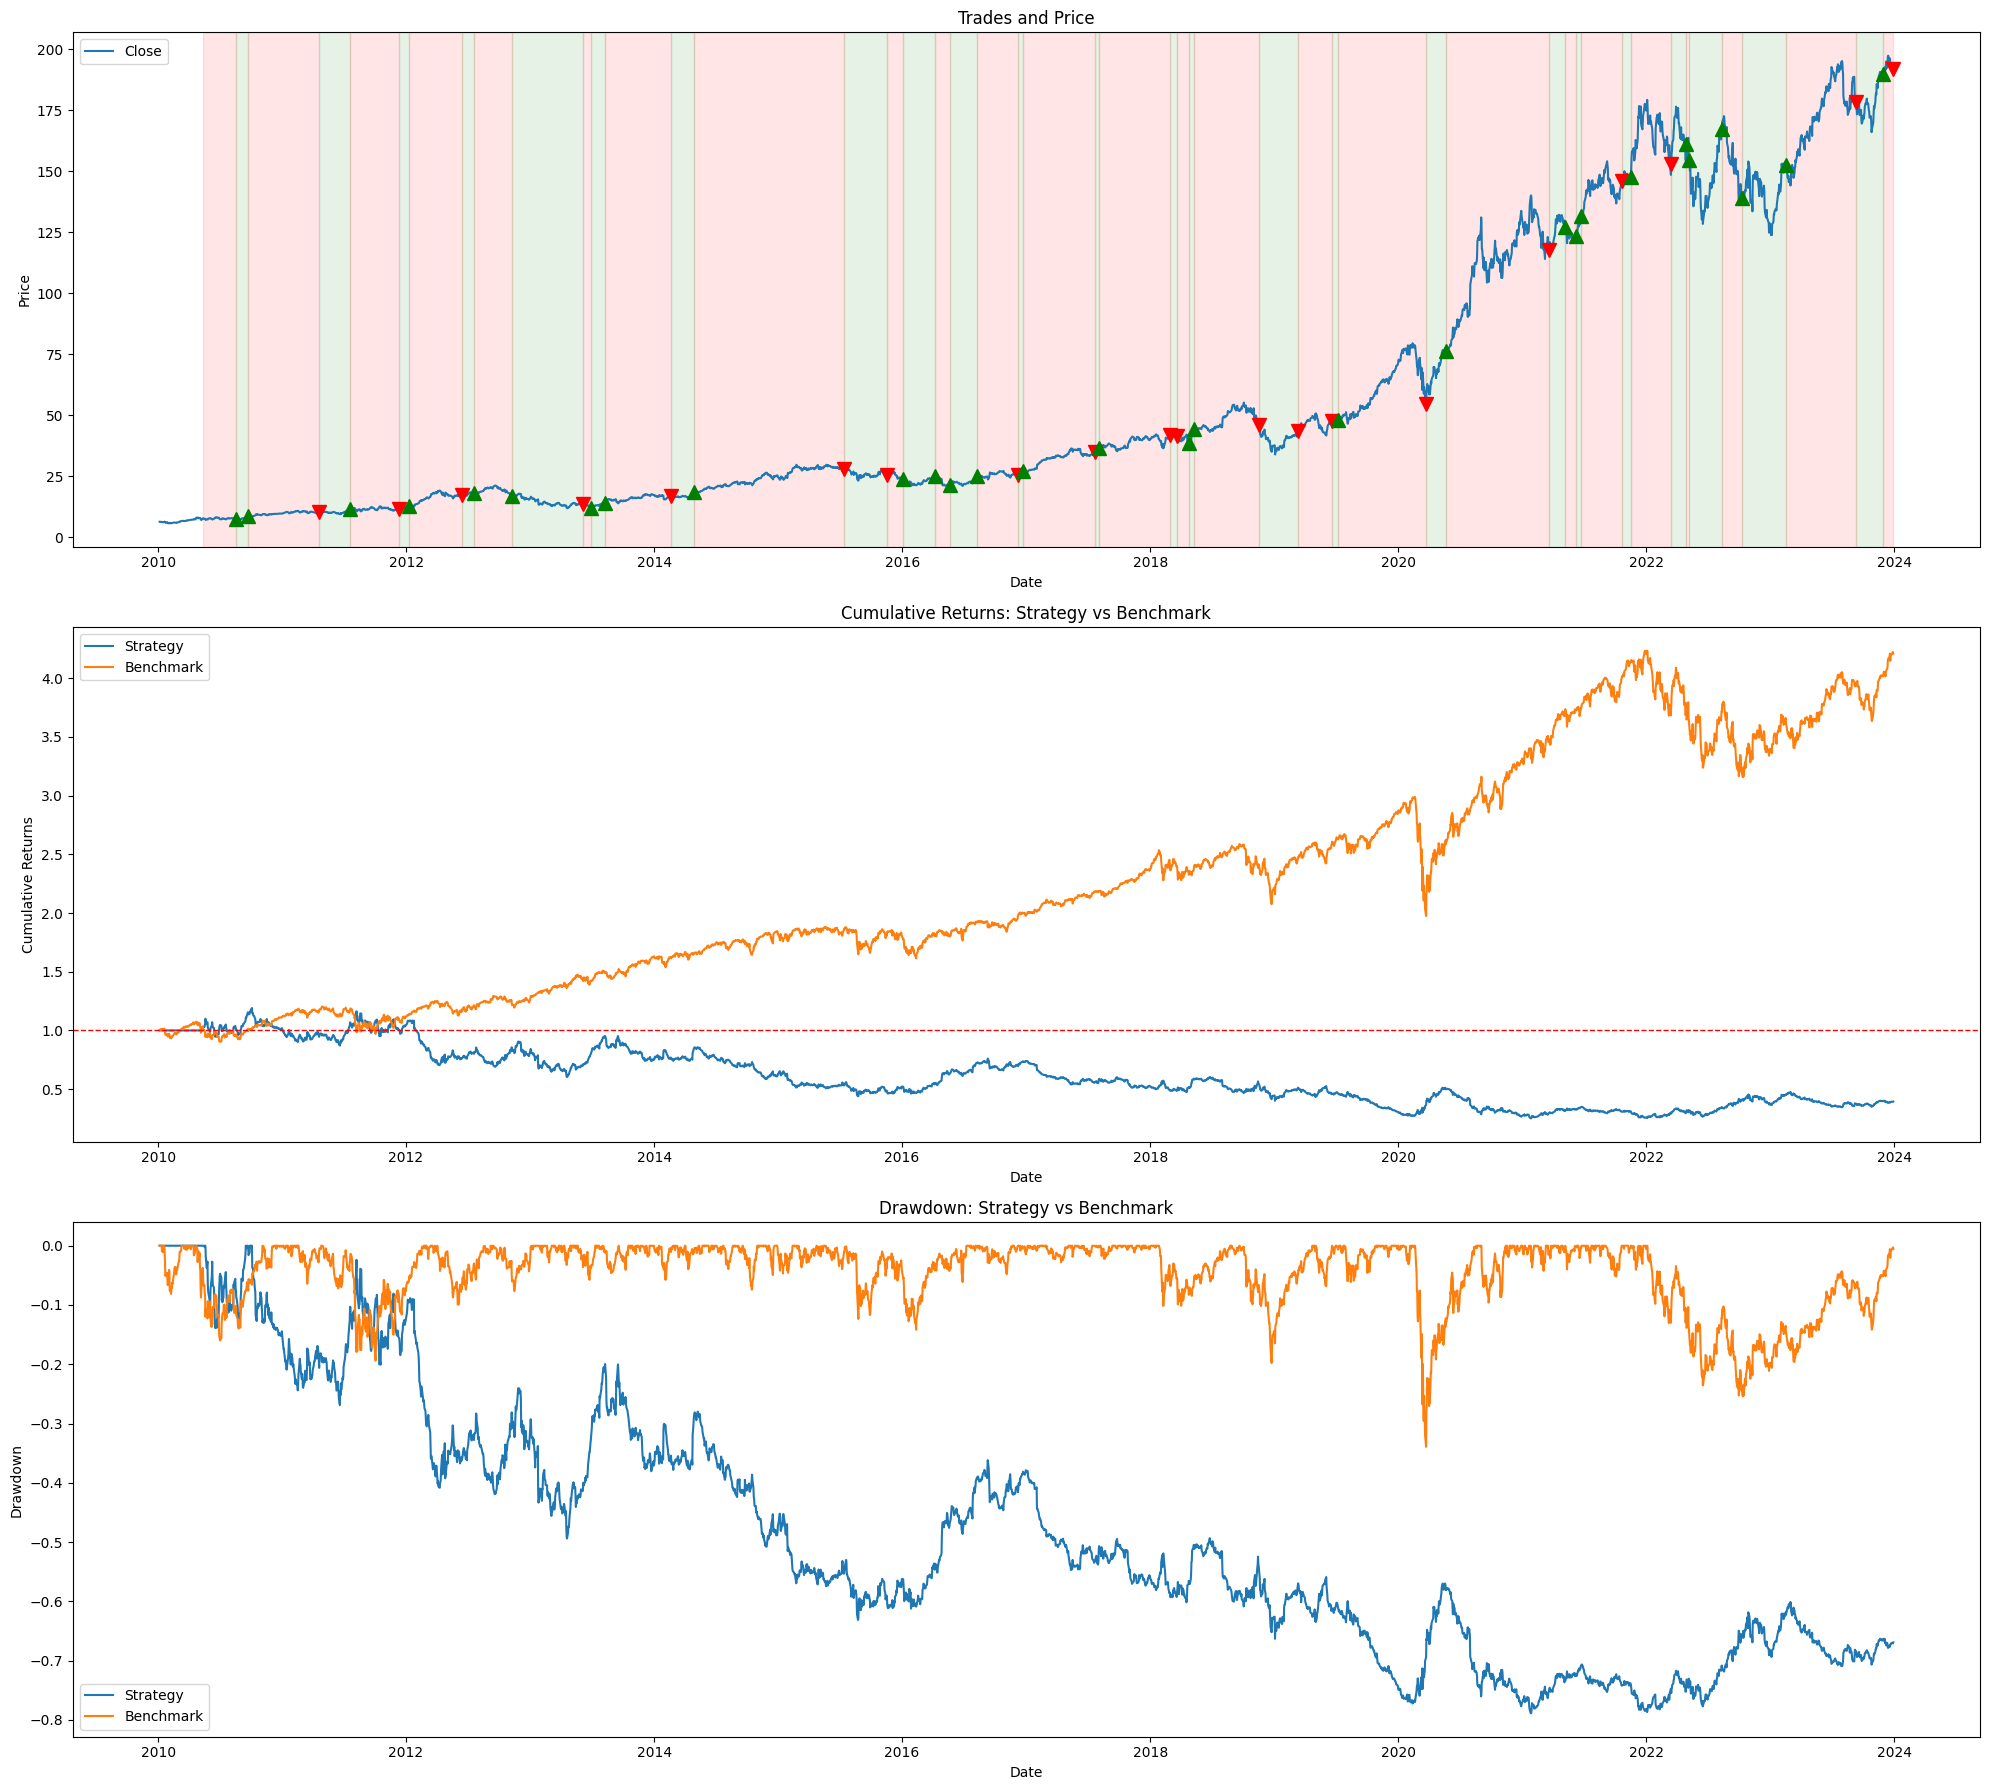

In [24]:
mastrategy.plot_performance()